In [123]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

In [124]:
batch_size = 64
img_height = 180
img_width = 180

In [125]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "train",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5216 files belonging to 2 classes.


In [126]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "val",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16 files belonging to 2 classes.


In [127]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  "test",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 624 files belonging to 2 classes.


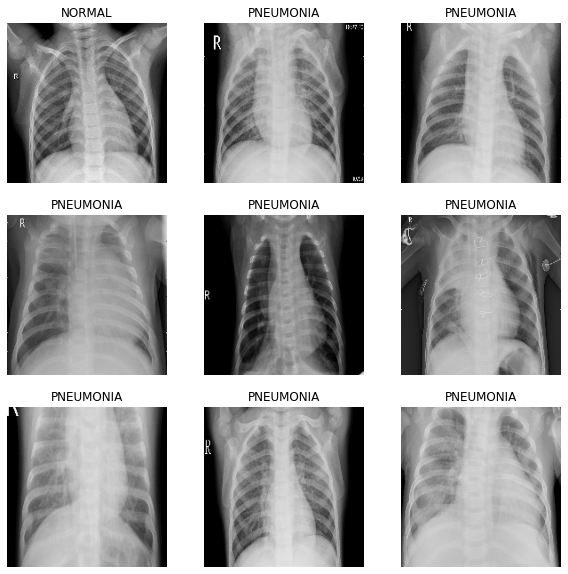

In [128]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [129]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 180, 180, 3)
(64,)


In [130]:
model = tf.keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(180, 180, 3),
    pooling=None,
    classes=1000,
)

In [131]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = model(image_batch)
print(feature_batch.shape)

(64, 6, 6, 2048)


In [132]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_20[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']      

In [133]:
from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typing import Optional
from tensorflow.keras import backend as K

class FBetaScore(tf.keras.metrics.Metric):
    def __init__(
        self,
        num_classes: FloatTensorLike,
        average: Optional[str] = None,
        beta: FloatTensorLike = 1.0,
        threshold: Optional[FloatTensorLike] = None,
        name: str = "fbeta_score",
        dtype: AcceptableDTypes = None,
        **kwargs,
    ):
        super().__init__(name=name, dtype=dtype)

        if average not in (None, "micro", "macro", "weighted"):
            raise ValueError(
                "Unknown average type. Acceptable values "
                "are: [None, 'micro', 'macro', 'weighted']"
            )

        if not isinstance(beta, float):
            raise TypeError("The value of beta should be a python float")

        if beta <= 0.0:
            raise ValueError("beta value should be greater than zero")

        if threshold is not None:
            if not isinstance(threshold, float):
                raise TypeError("The value of threshold should be a python float")
            if threshold > 1.0 or threshold <= 0.0:
                raise ValueError("threshold should be between 0 and 1")

        self.num_classes = num_classes
        self.average = average
        self.beta = beta
        self.threshold = threshold
        self.axis = None
        self.init_shape = []

        if self.average != "micro":
            self.axis = 0
            self.init_shape = [self.num_classes]

        def _zero_wt_init(name):
            return self.add_weight(
                name, shape=self.init_shape, initializer="zeros", dtype=self.dtype
            )

        self.true_positives = _zero_wt_init("true_positives")
        self.false_positives = _zero_wt_init("false_positives")
        self.false_negatives = _zero_wt_init("false_negatives")
        self.weights_intermediate = _zero_wt_init("weights_intermediate")

    def update_state(self, y_true, y_pred, sample_weight=None):
        if self.threshold is None:
            threshold = tf.reduce_max(y_pred, axis=-1, keepdims=True)
            # make sure [0, 0, 0] doesn't become [1, 1, 1]
            # Use abs(x) > eps, instead of x != 0 to check for zero
            y_pred = tf.logical_and(y_pred >= threshold, tf.abs(y_pred) > 1e-12)
        else:
            y_pred = y_pred > self.threshold

        y_true = tf.cast(y_true, self.dtype)
        y_pred = tf.cast(y_pred, self.dtype)

        def _weighted_sum(val, sample_weight):
            if sample_weight is not None:
                val = tf.math.multiply(val, tf.expand_dims(sample_weight, 1))
            return tf.reduce_sum(val, axis=self.axis)


        
        y_pred = tf.reshape(tf.cast(y_pred, self.dtype), [-1, self.num_classes])
        y_true = tf.reshape(tf.cast(y_true, self.dtype), [-1, self.num_classes])

        #print("y_pred shape: ",tf.shape(y_pred))
        #print("y_true shape: ",tf.shape(y_true))

        self.true_positives.assign_add(_weighted_sum(y_pred * y_true, sample_weight))
        self.false_positives.assign_add(
            _weighted_sum(y_pred * (1 - y_true), sample_weight)
        )
        self.false_negatives.assign_add(
            _weighted_sum((1 - y_pred) * y_true, sample_weight)
        )
        self.weights_intermediate.assign_add(_weighted_sum(y_true, sample_weight))

    def result(self):
        precision = tf.math.divide_no_nan(
            self.true_positives, self.true_positives + self.false_positives
        )
        recall = tf.math.divide_no_nan(
            self.true_positives, self.true_positives + self.false_negatives
        )

        mul_value = precision * recall
        add_value = (tf.math.square(self.beta) * precision) + recall
        mean = tf.math.divide_no_nan(mul_value, add_value)
        f1_score = mean * (1 + tf.math.square(self.beta))

        if self.average == "weighted":
            weights = tf.math.divide_no_nan(
                self.weights_intermediate, tf.reduce_sum(self.weights_intermediate)
            )
            f1_score = tf.reduce_sum(f1_score * weights)

        elif self.average is not None:  # [micro, macro]
            f1_score = tf.reduce_mean(f1_score)

        return f1_score

    def get_config(self):
        """Returns the serializable config of the metric."""

        config = {
            "num_classes": self.num_classes,
            "average": self.average,
            "beta": self.beta,
            "threshold": self.threshold,
        }

        base_config = super().get_config()
        return {**base_config, **config}

    def reset_state(self):
        reset_value = tf.zeros(self.init_shape, dtype=self.dtype)
        K.batch_set_value([(v, reset_value) for v in self.variables])

    def reset_states(self):
        # Backwards compatibility alias of `reset_state`. New classes should
        # only implement `reset_state`.
        # Required in Tensorflow < 2.5.0
        return self.reset_state()

In [134]:
class F1Score_TEST(FBetaScore):
    def __init__(
        self,
        num_classes: tfa.utils.types.FloatTensorLike,
        average: str = None,
        threshold: Optional[tfa.utils.types.FloatTensorLike] = None,
        name: str = "f1_score",
        dtype: tfa.utils.types.AcceptableDTypes = None,
    ):
        super().__init__(num_classes, average, 1.0, threshold, name=name, dtype=dtype)

    def get_config(self):
        base_config = super().get_config()
        del base_config["beta"]
        return base_config

In [135]:
model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

data_augmentation = tf.keras.Sequential([tf.keras.layers.Rescaling(1./127.5, offset=-1)])

inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
#x = preprocess_input(x)
x = model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

f1_score = F1Score_TEST(num_classes = 2, average='weighted', threshold = 0.5)
base_learning_rate = 0.01
model.compile(optimizer=tfa.optimizers.RectifiedAdam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy', f1_score])

(64, 2048)
(64, 1)


In [136]:
initial_epochs = 10

loss0, accuracy0, f1score0 = model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
print("initial f1_score: {:.2f}".format(f1score0))

1/1 [==============================] - 3s 3s/step - loss: 0.7554 - accuracy: 0.5000 - f1_score: 0.6853
initial loss: 0.76
initial accuracy: 0.50
initial f1_score: 0.69


In [139]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    use_multiprocessing = True)

Epoch 1/10
82/82 [==============================] - 284s 3s/step - loss: 0.5312 - accuracy: 0.7362 - f1_score: 0.8326 - val_loss: 0.7876 - val_accuracy: 0.5625 - val_f1_score: 0.6970
Epoch 2/10
82/82 [==============================] - 281s 3s/step - loss: 0.4087 - accuracy: 0.8169 - f1_score: 0.8785 - val_loss: 0.8528 - val_accuracy: 0.6250 - val_f1_score: 0.7273
Epoch 3/10
82/82 [==============================] - 254s 3s/step - loss: 0.3511 - accuracy: 0.8553 - f1_score: 0.9028 - val_loss: 0.8021 - val_accuracy: 0.6875 - val_f1_score: 0.8611
Epoch 4/10
82/82 [==============================] - 240s 3s/step - loss: 0.3071 - accuracy: 0.8808 - f1_score: 0.9198 - val_loss: 0.7982 - val_accuracy: 0.6875 - val_f1_score: 0.7620
Epoch 5/10
82/82 [==============================] - 237s 3s/step - loss: 0.2807 - accuracy: 0.8900 - f1_score: 0.9256 - val_loss: 0.9042 - val_accuracy: 0.6250 - val_f1_score: 0.7273
Epoch 6/10
82/82 [==============================] - 237s 3s/step - loss: 0.2536 - acc

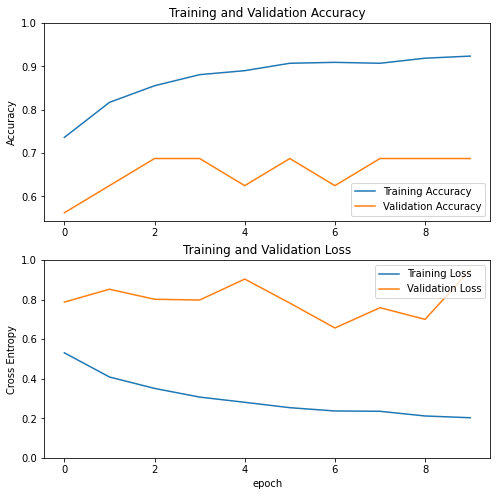

In [140]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [141]:
loss, accuracy, f1score = model.evaluate(test_ds)

print("loss: {:.2f}".format(loss))
print("accuracy: {:.2f}".format(accuracy))
print("f1 score: {:.2f}".format(f1score))

10/10 [==============================] - 42s 4s/step - loss: 0.6742 - accuracy: 0.7372 - f1_score: 0.8248
loss: 0.67
accuracy: 0.74
f1 score: 0.82
